In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Prepare data

In [2]:
df = pd.read_pickle('../data/process/schools2017.pkl')
print(df.shape[0], "schools")

594 schools


In [3]:
# drop 2 schools missing everything

df = df[df['School Name'].notnull()]
print(df.shape[0], "schools after removing bad bad entries")

592 schools after removing bad bad entries


In [4]:
df_fit = df[df['% SHSAT Testers'].notnull()]

In [5]:
# schools missing ELA
bad_ela = df[df['Mean Scale Score - ELA'].isnull()]

# schools missing Math
bad_math = df[df['Mean Scale Score - Math'].isnull()]

# schools missing presence
bad_presence = df[df['Percent of Students Chronically Absent'].isnull()]

# Create models

In [6]:
def cross_validate(inputs, outputs):
    # drop rows with NaN
    inputs = inputs[
        inputs.notnull().all(axis=1) &
        outputs.notnull()
    ]
    outputs = outputs.reindex(inputs.index)
    
    # cross-validation
    cv_results = []
    n_splits = 10
    n_repeats = 20
    for n_components in range(1, inputs.shape[1] + 1):
        mae_scores = []
        mse_scores = []

        x = PCA(n_components).fit_transform(inputs)
        x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
        x['Constant'] = 1
        y = outputs.copy()


        cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
        for train, test in cv.split(x):
            x_train = x.iloc[train]
            x_test = x.iloc[test]
            y_train = y.iloc[train]
            y_test = y.iloc[test]

            model = sm.RLM(y_train, x_train)
            results = model.fit()
            predictions = model.predict(results.params, exog=x_test)
            mae = median_absolute_error(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            mae_scores.append(mae)
            mse_scores.append(mse)

        mae_scores = np.array(mae_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat

        mae_mean = np.mean(mae_scores)
        mae_std = np.std(mae_scores)
        mse_mean = np.mean(mse_scores)
        mse_std = np.std(mse_scores)

        cv_result = (n_components, mae_mean, mse_mean, mae_std, mse_std)
        cv_results.append(cv_result)

    df_columns = ['n_components', 'mae__mean', 'mse__mean', 'mae__std', 'mse__std']
    cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
    return cv_results_df

def visualize_cv(df):
    plt.figure()
    plt.errorbar(df.n_components, df.mae__mean, df.mae__std, marker='o', label='Median Absolute Error')
    plt.legend()

    plt.figure()
    plt.errorbar(df.n_components, df.mse__mean, df.mse__std, marker='o', label='Mean Squared Error')
    plt.legend();

## Model 0 - All information available

In [7]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].notnull() &
    df['Mean Scale Score - Math'].notnull() &
    df['Percent of Students Chronically Absent'].notnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

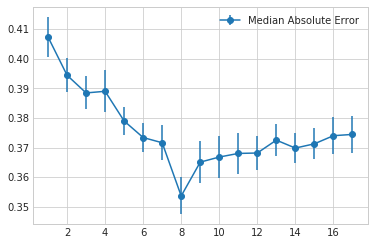

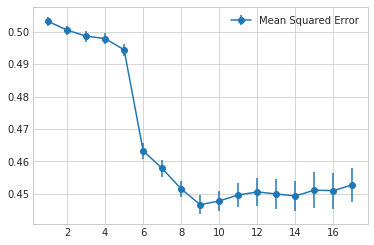

In [8]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [9]:
def prepare_inputs(df):    
    n_components = 8
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

predictions0 = predictions.reindex(target_rows.index)

In [10]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.34255265243940225
Mean Squared Error: 0.434734605389103


## Model 1 - Missing presence information

In [11]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].notnull() &
    df['Mean Scale Score - Math'].notnull() &
    df['Percent of Students Chronically Absent'].isnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
#     'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

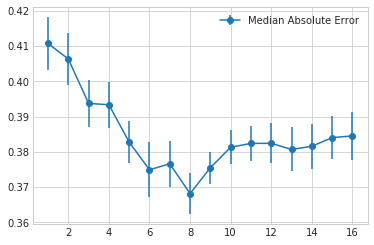

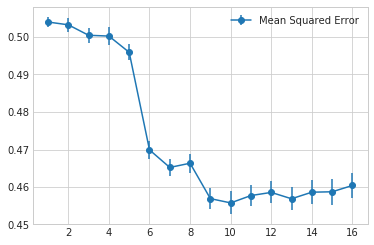

In [12]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [13]:
def prepare_inputs(df):    
    n_components = 8
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

predictions1 = predictions.reindex(target_rows.index)

In [14]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.3574112014529458
Mean Squared Error: 0.4507590802968464


## Model 2 - No NYS Math information

In [15]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].notnull() &
    df['Mean Scale Score - Math'].isnull() &
    df['Percent of Students Chronically Absent'].notnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
#     'Mean Scale Score - Math',
#     '% Level 2 - Math',
#     '% Level 3 - Math',
#     '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

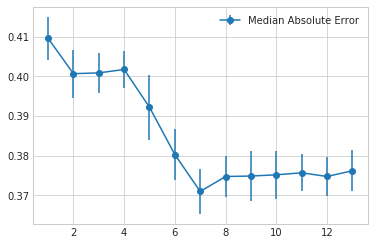

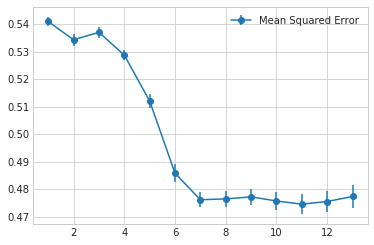

In [16]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [17]:
def prepare_inputs(df):    
    n_components = 7
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

predictions2 = predictions.reindex(target_rows.index)

In [18]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.3686692307441022
Mean Squared Error: 0.46005710406564


## Model 3 - No NYS ELA or Math information

In [19]:
target_rows = df.loc[
    df['School Name'].notnull() &
    df['Mean Scale Score - ELA'].isnull() &
    df['Mean Scale Score - Math'].isnull() &
    df['Percent of Students Chronically Absent'].notnull()    
]

explan_variables = [
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
#     'Mean Scale Score - ELA',
#     '% Level 2 - ELA',
#     '% Level 3 - ELA',
#     '% Level 4 - ELA',
#     'Mean Scale Score - Math',
#     '% Level 2 - Math',
#     '% Level 3 - Math',
#     '% Level 4 - Math', 
]

# fit values
inputs = df[explan_variables]
outputs = logit(df['% SHSAT Testers'])

nanrows = inputs.isnull().any(axis=1)
inputs = inputs[~nanrows]
outputs = outputs[~nanrows]

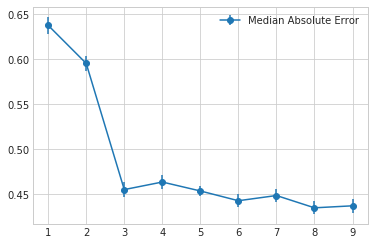

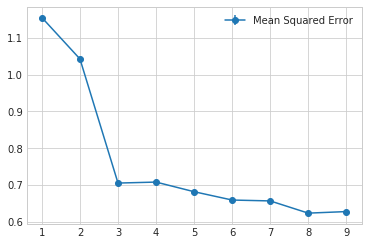

In [20]:
cvdf = cross_validate(inputs, outputs)
visualize_cv(cvdf)

In [21]:
def prepare_inputs(df):    
    n_components = 6
    columns = ["PC{}".format(i+1) for i in range(n_components)]
    
    # PCA
    pca = PCA(n_components)
    transformed = pca.fit_transform(df)
    transformed = pd.DataFrame(transformed, index=df.index, columns=columns)

    # aditional column
    inputs = transformed
    inputs.insert(0, 'Constant', 1.0)
    
    return inputs

model = sm.RLM(outputs, prepare_inputs(inputs), missing='drop')
results = model.fit()
predictions = model.predict(results.params, exog=prepare_inputs(inputs))
predictions = pd.Series(predictions, index=inputs.index)

predictions3 = predictions.reindex(target_rows.index)

In [22]:
_outputs = outputs.dropna()
_predictions = predictions.reindex(_outputs.index)

mae = median_absolute_error(_outputs, _predictions)
mse = mean_squared_error(_outputs, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.4360797441234471
Mean Squared Error: 0.6454383246352795


Heya!